# ECD-UY: Technical validation of the Total Household Consumption subset

This notebook presents the minimum code steps to load the subset and start to work with its records.

In [1]:
# python
import datetime
from typing import List, Tuple, Union
import glob
from os.path import join, exists
from os import makedirs
import warnings
from datetime import datetime, timedelta

# data-science
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")
import ciso8601
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print("Pandas version {}".format(pd.__version__))

from dask.system import CPU_COUNT
print("Available cores: {}".format(CPU_COUNT), flush=True)

Populating the interactive namespace from numpy and matplotlib
Pandas version 1.2.1
Available cores: 4


/Users/jp/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Download the subset

In [2]:
# !curl -O https://url-to-repo/ecd-uy/total-household-consumption-subset.tar.gz
# !tar xzf electric-water-heater.tar.gz

## Declare the path where the files are located

In [3]:
BASE_PATH = "../../../datasets/"
BASE_DATA_SOURCE = BASE_PATH + "/ECD-UY/total-household-subset"

## Setup local dask cluster

In [4]:
print("Generating Dask Client...", flush=True)
client = Client(threads_per_worker=2)

Generating Dask Client...


## Load customers data

In [5]:
data_customers = pd.read_csv(
    BASE_DATA_SOURCE + '/customers.csv',
)
data_customers.head()

,customer_id,tension,tariff,power,department,section,segment,zone
0,2,BT 230 V,TCB,3700,3,5,4,19
1,3,BT 230 V,TRS,2200,3,4,14,7
2,5,BT 230 V,TRS,2200,13,3,303,19
3,6,BT 230 V,TCB,3700,19,1,124,800
4,9,BT 230 V,TCB,3700,15,8,302,600


## Load total consumption data 

In [6]:
from os.path import join, exists

if not exists(BASE_DATA_SOURCE + '/consumption-parquet'):
    dd.read_csv(
        BASE_DATA_SOURCE + '/consumption_data_*.csv',
        delimiter=',',
        header=0,
        names=["datetime", "id", "value"],
        dtype={'id': np.int32, 'value': np.float32},
        parse_dates=["datetime"],
        date_parser=lambda epoch: pd.Timestamp(int(epoch), unit='s', tz='America/Montevideo'),
    ).to_parquet(
        BASE_DATA_SOURCE + '/consumption-parquet',
        engine='pyarrow',
        compression='snappy',
        write_index=False
    )
    

df_consum = dd.read_parquet(
    BASE_DATA_SOURCE + '/consumption-parquet',
)

df_consum.head()

,datetime,id,value
0,2019-01-01 00:00:00-03:00,10669,0.056
1,2019-01-01 00:00:00-03:00,109371,0.000
2,2019-01-01 00:00:00-03:00,109829,0.386
3,2019-01-01 00:00:00-03:00,109846,0.027
4,2019-01-01 00:00:00-03:00,110088,0.000


### Filter outliers records

Filter the ON records (values greater than zero) that are over percentile 99%.

In [7]:
percentile = df_consum[["value"]][df_consum.value > 0].quantile(
    [.8, .9, .95, .975, .98, .985, .99, .995, 1]
).compute()
display(percentile)

0.800       0.237000
0.900       0.390000
0.950       0.532000
0.975       0.674000
0.980       0.716000
0.985       0.819000
0.990       1.006000
0.995     156.899994
1.000    2469.600098
Name: value, dtype: float64

In [8]:
percentile[0.99]

1.00600004196167

In [9]:
df_consum = df_consum[df_consum.value <= percentile[0.99]]

## Mean consumption per hour
Average total consumption per hour of the day.

<AxesSubplot:xlabel='datetime'>

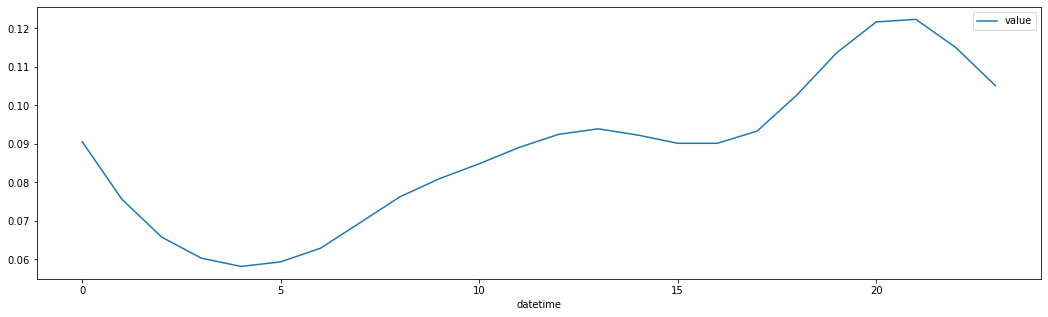

In [10]:
df_consum.groupby(df_consum.datetime.dt.hour).mean().compute().plot(y='value')

## Mean consumption per 15-minutes periods
Average total consumption per 15-minutes periods.

In [11]:
df_consum_15min = df_consum[["datetime", "value"]].set_index("datetime").resample("15min").mean()

df_consum_15min_mean = df_consum_15min[["value"]].groupby(
    [df_consum_15min.index.hour, df_consum_15min.index.minute]
).aggregate({"value": ["mean", "std"]}) 

df_consum_15min_mean = df_consum_15min_mean.compute()

df_consum_15min_mean.head()

value          
                       mean       std
datetime datetime                    
0        0         0.096923  0.013334
         15        0.093004  0.013034
         30        0.088933  0.012642
         45        0.084956  0.012236
1        0         0.081231  0.012017

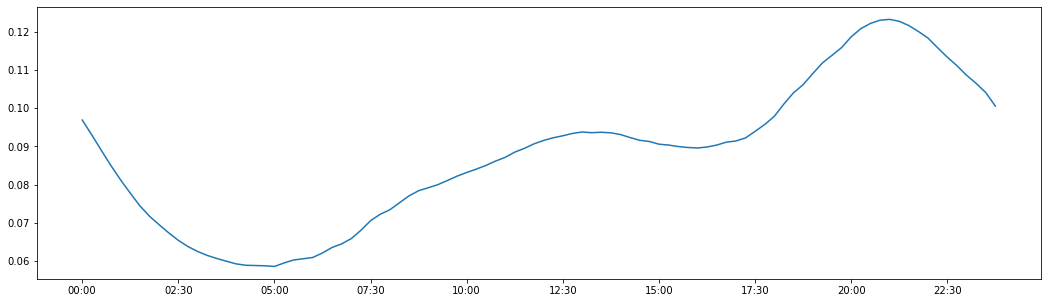

In [12]:
x_ticks = ["{:02d}:{:02d}".format(x,y) for x,y in df_consum_15min_mean.index]
plt.plot(
    x_ticks,
    df_consum_15min_mean[("value", "mean")]
)

plt.xticks([x_ticks[x] for x in range(0,len(x_ticks), 10)], rotation=0)
plt.show()

## Count records per day and customer

In [13]:
df_consum_date_count = df_consum.groupby(
    [df_consum.id, df_consum.datetime.dt.date]
)[["value"]].count().compute()

In [14]:
df_consum_date_count.head()

value
id   datetime         
1168 2019-01-01     96
     2019-01-02     96
     2019-01-03     96
     2019-01-04     96
     2019-01-05     96

[0.0, 9.6, 19.2, 28.799999999999997, 38.4, 48.0, 57.599999999999994, 67.2, 76.8, 86.39999999999999, 96.0]


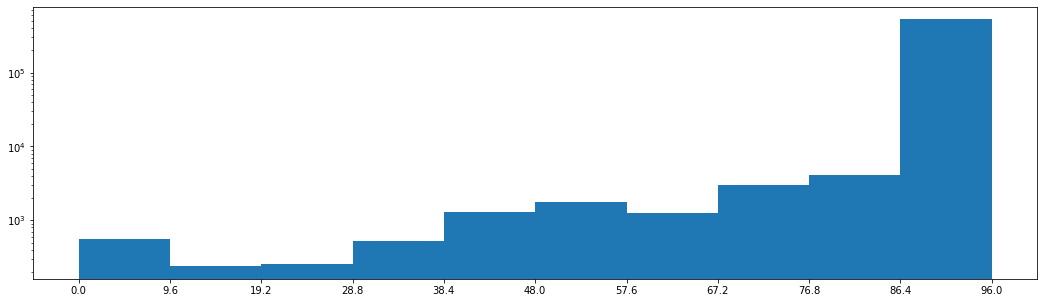

In [15]:
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# fig.subplots_adjust(hspace=0.05)
print([(96/10)*x for x in range(11)])
plt.hist(df_consum_date_count.value, bins=[(96/10)*x for x in range(11)])
plt.yscale('log', nonposy='clip')
plt.xticks([(96/10)*x for x in range(11)])
plt.show()

In [16]:
df_consum_date_count.value.value_counts()

96    510871
95      6965
94      2937
72      1737
81      1723
       ...  
20        20
16        20
12        20
14        16
11        15
Name: value, Length: 96, dtype: int64

In [17]:
b = pd.cut(df_consum_date_count.value, bins=[(96/20)*x for x in range(21)])
df_consum_date_count.value.groupby(b).count()

value
(0.0, 4.8]         294
(4.8, 9.6]         266
(9.6, 14.4]        100
(14.4, 19.2]       137
(19.2, 24.0]       121
(24.0, 28.8]       135
(28.8, 33.6]       247
(33.6, 38.4]       275
(38.4, 43.2]       818
(43.2, 48.0]       874
(48.0, 52.8]       512
(52.8, 57.6]       893
(57.6, 62.4]       377
(62.4, 67.2]       862
(67.2, 72.0]      2184
(72.0, 76.8]       817
(76.8, 81.6]      2889
(81.6, 86.4]      1189
(86.4, 91.2]      3905
(91.2, 96.0]    523391
Name: value, dtype: int64

## Mean consumption per 15-minutes periods, using days with >= 95% of records

In [18]:
df_consum_filter95 = df_consum
df_consum_date_count = df_consum.groupby(
    [df_consum.id, df_consum.datetime.dt.date]
).value.count().reset_index()
df_consum_date_count = df_consum_date_count[df_consum_date_count.value > 91]
df_consum_date_count["datetime"] = dd.to_datetime(df_consum_date_count.datetime)

df_consum_date_count.head()
# df_consum_date_count.reset_index()[[""]].head()

,id,datetime,value
0,1168,2019-01-01,96
1,1168,2019-01-02,96
2,1168,2019-01-03,96
3,1168,2019-01-04,96
4,1168,2019-01-05,96


In [19]:
df_consum_2 = df_consum
df_consum_2["datetime2"] = dd.to_datetime(df_consum_2.datetime.dt.date)

df_consum_filter95 = dd.merge(
    df_consum_2,
    df_consum_date_count,
    left_on=["id", "datetime2"],
    right_on=["id", "datetime"],
    how='left',
    indicator='exists'
)
df_consum_filter95 = df_consum_filter95[df_consum_filter95.exists=="both"]
df_consum_filter95 = df_consum_filter95.drop(["datetime2", "datetime_y", "exists"], axis="columns")
df_consum_filter95 = df_consum_filter95.rename(columns={
    "datetime_x": "datetime",
    "value_x": "value",
    "value_y": "records_of_day",
})

df_consum_filter95.compute()

,datetime,id,value,records_of_day
0,2019-01-01 00:00:00-03:00,10669,0.056,96.0
1,2019-01-01 00:00:00-03:00,109371,0.000,96.0
2,2019-01-01 00:00:00-03:00,109829,0.386,96.0
3,2019-01-01 00:00:00-03:00,109846,0.027,96.0
4,2019-01-01 00:00:00-03:00,110088,0.000,96.0
...,...,...,...,...
318497,2020-11-06 23:45:00-03:00,90478,0.010,96.0
318498,2020-11-06 23:45:00-03:00,90549,0.059,96.0
318499,2020-11-06 23:45:00-03:00,96637,0.082,96.0
318500,2020-11-06 23:45:00-03:00,96690,0.089,96.0


## Plot of the 15-minutes mean consumptio of the day for 4 different customers

In [32]:
def filter_cust_n_group(cust_id):
    df_cust = df_consum[(df_consum.id==cust_id)]
    return df_cust.groupby(
        [df_cust.datetime.dt.hour, df_cust.datetime.dt.minute]
    ).mean()

def min_max_dt(cust_id: int) -> (datetime, datetime):
    df_cust = df_consum[(df_consum.id==cust_id)]
    min_dt = df_cust.datetime.min()
    max_dt = df_cust.datetime.max()
    
    return dd.compute(min_dt, max_dt)
    
def plot_consum(df, hide_xticks=False):
    x_ticks = ["{:02d}:{:02d}".format(x,y) for x,y in df.index]
    plt.plot(x_ticks, df.value)
    plt.grid(True, axis='y')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel("Mean energy consumption (kWh)", fontsize=18)
    
    if hide_xticks:
        plt.xticks([], rotation=0)
    else:
        plt.xlabel("Hour of the day", fontsize=18)
        plt.xticks([x_ticks[x] for x in range(0,len(x_ticks), 10)], rotation=0)
    plt.show()

### Customer 109846

In [21]:
df_consum_c1 = filter_cust_n_group(109846).compute()

In [33]:
print(min_max_dt(109846))

(Timestamp('2019-01-01 00:00:00-0300', tz='America/Montevideo'), Timestamp('2020-11-03 20:00:00-0300', tz='America/Montevideo'))


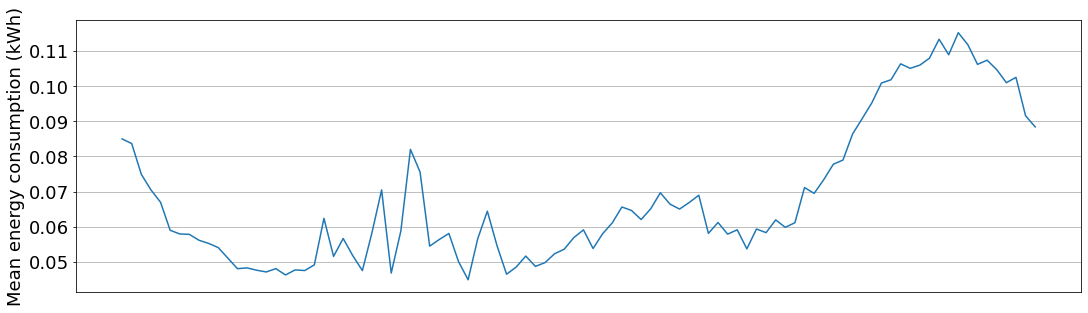

In [22]:
plot_consum(df_consum_c1, hide_xticks=True)

### Customer 110088

In [23]:
df_consum_c2 = filter_cust_n_group(110088).compute()

In [36]:
print(min_max_dt(110088))

(Timestamp('2019-01-01 00:00:00-0300', tz='America/Montevideo'), Timestamp('2020-11-02 20:00:00-0300', tz='America/Montevideo'))


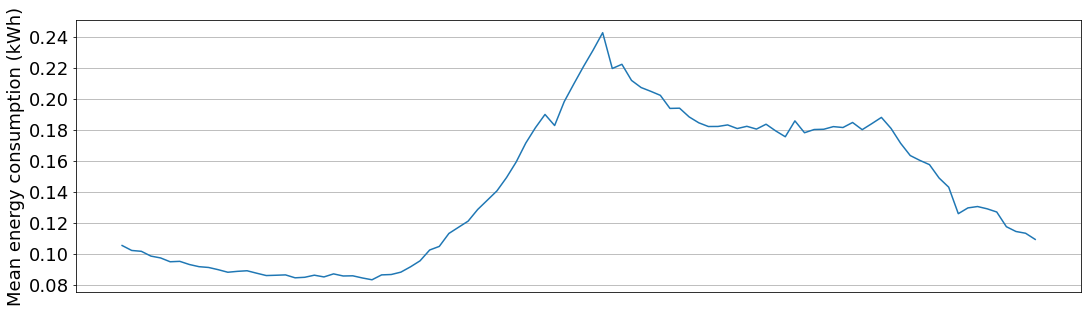

In [24]:
plot_consum(df_consum_c2, hide_xticks=True)

### Customer 97875

In [25]:
df_consum_c3 = filter_cust_n_group(97875).compute()

In [35]:
print(min_max_dt(97875))

(Timestamp('2019-03-21 16:30:00-0300', tz='America/Montevideo'), Timestamp('2020-11-07 02:00:00-0300', tz='America/Montevideo'))


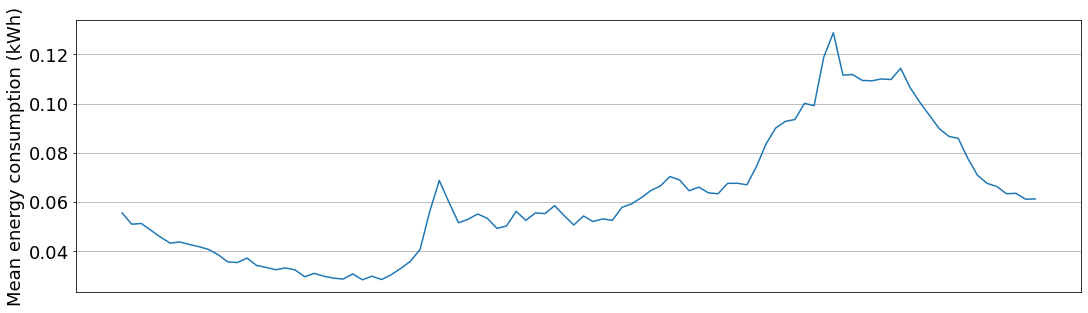

In [26]:
plot_consum(df_consum_c3, hide_xticks=True)

### Customer 8037

In [27]:
df_consum_c4 = filter_cust_n_group(8037).compute()

In [34]:
print(min_max_dt(8037))

(Timestamp('2019-01-01 00:00:00-0300', tz='America/Montevideo'), Timestamp('2020-11-03 12:00:00-0300', tz='America/Montevideo'))


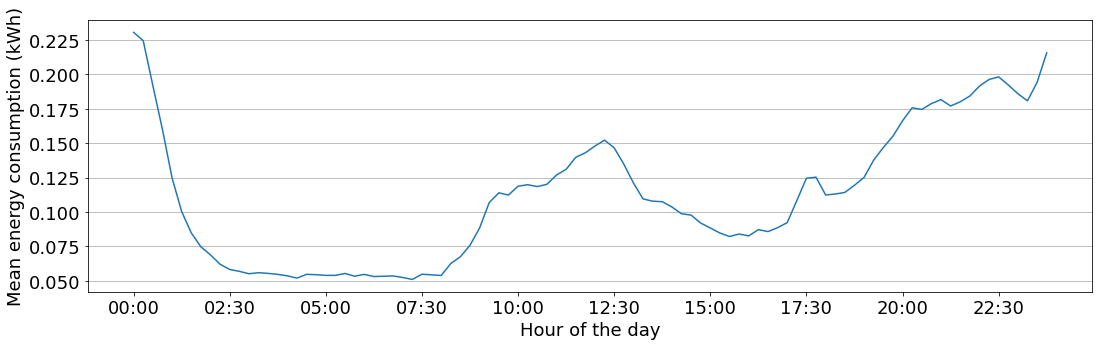

In [28]:
plot_consum(df_consum_c4, hide_xticks=False)

In [29]:
df_consum.value.max().compute()

1.00600004196167